In [1]:
import os
import math

import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.heat.heat_diffusion import HeatDiffusion, HeatDiffusion_Revised
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import (
    gen_goals, overlay_goal, overlay_multiple, combine_objects, overlay_images,
    overlay_goal_agent, overlay_goals_agent, log_num_check,
    draw_obstacles_pil, convert_to_obstacle_masks,
    randgen_obstacle_masks, draw_obstacles_pixel,
    vector_field, clip_vectors
)
from scorefield.utils.diffusion_utils import bilinear_interpolate, bilinear_interpolate_samples

import matplotlib.pyplot as plt
import itertools
from typing import Optional
import shutil


# Args
config_dir = "./scorefield/configs/heat_diffusion.yaml"
args = load_config(config_dir)
device = args['device']

bg = Image.open('assets/toy_exp/background0.png')
wastes = []
wastes.append(Image.open('assets/toy_exp/waste0.png'))
# wastes.append(Image.open('assets/toy_exp/waste4.png'))
# wastes.append(Image.open('assets/toy_exp/waste5.png'))


img_size = args['image_size']
goal_bounds = args['goal_bounds']
goal_num = len(wastes)
agent_bounds = args['agent_bounds']
obstacle_pos = args['obstacles']

model_path = os.path.join(args['log_path'], args['model_path'])

u0 = args['u0']
min_heat_step = args['min_heat_step']
max_heat_step = args['max_heat_step']
noise_steps = args['noise_steps']
sample_num = args['sample_num']
time_type = args['time_type']

train_lr = args['train_lr']
batch_size = noise_steps #args['batch_size']

class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8),
    ):
        super().__init__(dim=dim, out_dim=out_dim, dim_mults=dim_mults)

    def forward(self, obs, t, x_t:Optional[torch.Tensor]=None):
        score_map = super().forward(obs, t)
        if x_t is not None:
            score = bilinear_interpolate_samples(score_map, x_t)    # output: (B,2)
            return score, score_map.permute(0,2,3,1)
        else:
            return score_map.permute(0, 2, 3, 1)
    
model = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

diffusion = HeatDiffusion_Revised(
    image_size=img_size,
    u0 = u0,
    noise_steps=noise_steps,
    min_heat_step=min_heat_step,
    max_heat_step=max_heat_step,
    time_type=time_type,
    device=device,
)

dt:tensor([    8,    50,   162,   392,   882,  1568,  2888,  5202,  8712, 14450],
       device='cuda:0')
heat kernel std:tensor([ 2.,  5.,  9., 14., 14., 14., 14., 14., 14., 14.], device='cuda:0')


In [2]:
model.load_state_dict(torch.load(f'./runs/Sep10_08-44-34_workspace-ryae9dru7a3u-0/model_params.pt'))

<All keys matched successfully>

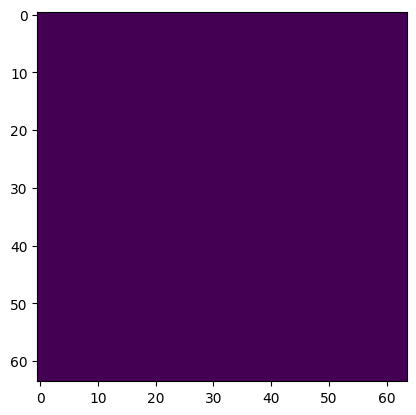

In [9]:
# Evaluation pre-setting

# background = draw_obstacles_pil(bg, obstacle_pos)
# obstacle_masks = convert_to_obstacle_masks(noise_steps, background[0].size, img_size, obstacle_pos)
obstacle_masks = randgen_obstacle_masks(1, img_size)
background = draw_obstacles_pixel(bg, obstacle_masks)

obstacle_masks = obstacle_masks[0].unsqueeze(0)

plt.imshow(obstacle_masks[0].cpu().numpy())
plt.show()

In [ ]:
# Evaluation - Single goal

lan_t = 200  # 4
epsilon = .01

goals = torch.tensor([[[-0.8, -0.8], [-0.8, 0.8]]], device=device, dtype=torch.float32)
obs_T = overlay_goal(background, img_size, wastes, goals)

c = 10
fig, axs = plt.subplots(goal_num, c, figsize=(20,20))

T = diffusion.noise_steps
step_size = int(T / c)
dot_size = 3


model.eval()
ims = []

with torch.no_grad():
    x_T = torch.tensor([[[0., 0.]]], device=device, dtype=torch.float32)
    x = x_T
    
    for i in tqdm(reversed(range(1, T+1)), position=0):
        if (T-i) % step_size == 0:
            k = (T-i) // step_size
            backg = background.copy()

            img_sample = overlay_goal_agent(backg, wastes, goals.cpu(), x.cpu(), dot_size)
            for s in range(len(img_sample)):
                if len(wastes) == 1:
                    axs[k].imshow(img_sample[s])
                    axs[k].set_title(f't = {T-i+1}')
                    axs[k].axis('off')    
                else:
                    axs[s,k].imshow(img_sample[s])
                    axs[0,k].set_title(f't = {T-i+1}')
                    axs[s,k].axis('off')

        t = (torch.ones(1) * i).long().to(device)

        alpha = epsilon / diffusion.std[i-1] * (img_size/2)
        
        for _ in range(lan_t):
            x_prev = x.clone()
            score, _ = model(obs_T, t, x)
            
            x = x_prev + (alpha * score)/2 + (torch.randn_like(x) * torch.sqrt(alpha) * 0.2)

            if not (x.abs() <=0.99).all():        
                x = x_prev
            bkg = background.copy()
            im = overlay_goal_agent(bkg, wastes, goals.cpu(), x.cpu(), dot_size)
            ims.append(im)

    backg = background.copy()
    img_sample = overlay_goal_agent(backg, wastes, goals.cpu(),x.cpu(), dot_size)
    for s in range(len(img_sample)):
        if len(img_sample) == 1:
            axs[-1].imshow(img_sample[s])
            axs[-1].set_title(f't = {T}')
            axs[-1].axis('off')    
        else:
            axs[s,-1].imshow(img_sample[s])
            axs[0,-1].set_title(f't = {T}')
            axs[s,-1].axis('off')

    bkg = background.copy()
    im = overlay_goal_agent(bkg, wastes, goals.cpu(), x.cpu(), dot_size)       
    ims.append(im)

7it [00:17,  2.51s/it]

In [22]:
np.save('./results/heat/eval.npy', ims)

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:518: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
# Create the whole field

i = 3

model.eval()

y = np.linspace(-1, 1, img_size)
x = np.linspace(-1, 1, img_size)
xx, yy = np.meshgrid(x,y)
coordinates = np.vstack((xx.ravel(), yy.ravel())).T
coordinates = torch.tensor(coordinates).float().to(device)

batch_size = 1024
all_scores = []
for j in tqdm(range(0, coordinates.size(0), batch_size)):
    coords_batch = coordinates[j:j+batch_size]
    
    score_batch = []
    for coord in coords_batch:
        single_coord = coord.unsqueeze(0).unsqueeze(1)
        with torch.no_grad():
            score, _ = model(obs_T, (torch.ones(1) * i).long().to(device), single_coord)
        score_batch.append(score.squeeze(1))
        
    all_scores.append(torch.stack(score_batch))
scores = torch.cat(all_scores, dim=0)
scores = scores.squeeze(1)

In [ ]:
# Visualizing the whole field

fig, axes = plt.subplots(1, 2, figsize=(20,10))

scores_x = scores[:, 1].reshape(img_size, img_size)
scores_y = scores[:, 0].reshape(img_size, img_size)
score_clip_x, score_clip_y = clip_vectors(scores_x, scores_y, 0.01)
axes[0].quiver(xx, yy, score_clip_x.detach().cpu().numpy(), score_clip_y.detach().cpu().numpy(), angles='xy', scale_units='xy', scale=0.5)
axes[0].invert_yaxis()
axes[0].set_xlim(-1,1)
axes[0].set_ylim(-1,1)

# Ground truth
obstacle_masks = convert_to_obstacle_masks(noise_steps, bg.size, img_size, obstacle_pos)
background = draw_obstacles_pixel(bg, obstacle_masks)
goal = torch.tensor([[[-0.7,-0.7]]]*noise_steps, device=device)
obs = overlay_goal(background, img_size, wastes, goal)
t = torch.tensor([i for i in range(1, noise_steps+1)], device=device)
_, _, score_field, _ = diffusion.forward_diffusion(t, goal, sample_num, obstacle_masks)
data = score_field[i]
V = data[...,0]
U = data[...,1]
V_clip, U_clip = clip_vectors(V, U, 0.005)
# V_clip, U_clip = V, U
x, y = np.meshgrid(np.linspace(0, img_size-1, img_size), np.linspace(0,img_size-1,img_size))
axes[1].quiver(x, y, U_clip.cpu().numpy(), V_clip.cpu().numpy(), angles='xy', scale_units='xy', scale=0.01)
# axes[1].invert_yaxis()

plt.show()

In [ ]:
# Evaluation - Multi goals

c = 10
fig,axs = plt.subplots(1, c + 1, figsize=(20,20))
axs = axs.flatten()
T = diffusion.noise_steps
step_size = int(T / c)
dot_size = 2

goals = gen_goals(goal_bounds, goal_num)

objs = wastes.copy()
gs = goals.clone()

obs_T = overlay_images(bg, img_size, objs, gs)

imgs = []

model.eval()
with torch.no_grad():
    # x_T = torch.tensor([[0.5, 0.5]], device=device, dtype=torch.float32)
    x_T = gen_goals(agent_bounds, n=(1, eval_samples)).unsqueeze(0)
    x = x_T
    
    imgs=[]
    for i in tqdm(reversed(range(1, noise_steps)), position=0):
        if (T-1-i) % step_size == 0:
            k = (T-1-i) // step_size
            img_sample = overlay_goals_agent(bg, objs, gs.cpu(), x.cpu(), dot_size)
            axs[k].imshow(img_sample)
            axs[k].set_title(f't = {T-1-i}')
            axs[k].axis('off')
            imgs.append(img_sample)

        t = (torch.ones(1) * i).long().to(device)
        while True:
            predicted_noise = model(obs_T, x, t)
            alpha = diffusion.alpha[t]
            alpha_hat = diffusion.alpha_hat[t]
            beta = diffusion.beta[t]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) \
                        * predicted_noise) + torch.sqrt(beta) * noise
            # if (abs(x[0][0]) <= 1.) & (abs(x[0][1]) <= 1.):
            #     break
            mask = (x.abs() > 1)
            x[mask] = torch.clamp(x[mask], min=-.9, max=.9)
            if (x.abs() <=1).all():
                break

#         exclude_idx = -1
#         for i in range(len(gs)):
#             if get_distance(x[0], gs[i]) < 0.1 and len(gs) > 1:
#                 exclude_idx = i
#                 break
#         if exclude_idx > -1:
#             objs = objs[:i] + objs[i+1:]
#             gs = torch.cat([gs[:i], gs[i+1:]], dim=0)
#             obs_T = overlay_images(bg, img_size, objs, gs)

    img_sample = overlay_goals_agent(bg, objs, gs.cpu(),x.cpu(), dot_size)
    axs[-1].imshow(img_sample)
    axs[-1].set_title(f't = {T}')
    axs[-1].axis('off')
    imgs.append(img_sample)